# Exploratory Data Analysis (EDA) for Stock Market Prediction

The dataset used in this analysis is obtained using Yahoo Finance’s `yfinance` API, which provides historical stock data including **Open**, **High**, **Low**, **Close**, **Volume**, and **Adjusted Close** prices. These are commonly referred to as **OHLCV** data, and they form the foundation for many technical analysis and trading strategies.

## What is Stock Market Prediction?

**Stock market prediction** is the process of attempting to determine the future value of a company stock or other financial instrument traded on an exchange. It’s a key application of financial analytics and machine learning, where the goal is often to predict the **direction** of stock prices (up or down) or forecast the **actual future price**.

The stock market is influenced by many factors including economic indicators, investor sentiment, earnings reports, geopolitical events, and market trends. While it's impossible to predict market movements with complete accuracy, we will use machine learning models to try to uncover patterns in historical data that improve short-term forecasts or trading decisions.

### Imports

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy import signal

### Using Yahoo Finance to Download Stock Data

In [2]:
def download_stock_data(tickers, start_date, end_date):
    df_list = []
    for ticker in tickers:
        data = yf.download(ticker, start=start_date, end=end_date)
        data['Symbol'] = ticker
        df_list.append(data.reset_index())
    return pd.concat(df_list, ignore_index=True)

## Feature engineering functions

### Data Cleaning 

A stock (symbol) is removed from the dataset if **any** of the following are true:

- **Low Close Price**: Any closing price is **less than 1**
- **Zero Volume**: The stock has **any day with zero trading volume**
- **Missing Open Data**: The stock has **missing (`NaN`) values** in the `Open` column

These conditions often indicate:
- Penny stocks
- Illiquid or halted stocks
- Incomplete data feeds


In [3]:
def delete_bad_data(dataframe):
    if "Symbol" not in dataframe.columns:
        dataframe = dataframe.reset_index()
    bad_symbols = []
    for stock in dataframe["Symbol"].unique():
        stock_data = dataframe[dataframe["Symbol"] == stock]

        low_close = stock_data["Close"].min() < 1
        zero_volume = stock_data["Volume"].eq(0).any()
        missing_open = stock_data["Open"].isnull().any()

        if low_close or zero_volume or missing_open:
            bad_symbols.append(stock)

    dataframe = dataframe[~dataframe["Symbol"].isin(bad_symbols)]
    return dataframe

### Relative Strength Index (RSI)

#### What is RSI?

The **Relative Strength Index (RSI)** is a **momentum oscillator** that measures the **speed and change** of price movements. It is used in technical analysis to evaluate whether an asset is **overbought** or **oversold** and can be used as a feature to indetify general trend.


#### RSI Scale

The RSI value ranges from **0 and 100**:

- **RSI > 70**: Typically considered **overbought**
- **RSI < 30**: Typically considered **oversold**


#### RSI Formula
Average Gain and Average Loss are computed over a period of time (typically 14 days)

- $`RS = \frac{Average Gain}{Average Loss}`$

- $`RSI =  100 - \frac{100}{1+RS}`$

In [4]:
def RSI(dataframe, period=14):
    rsi = []
    for stock in dataframe['Symbol'].unique():
        prices = dataframe[dataframe['Symbol'] == stock]['Close'].values
        diff = np.diff(prices)
        rsi.extend([None]*period)

        for i in range(len(diff) - period + 1):
            window = diff[i:i+period]
            avg_gain = np.mean(window[window >= 0]) if len(window[window >= 0]) > 0 else 0
            avg_loss = -np.mean(window[window < 0]) if len(window[window < 0]) > 0 else 0

            if avg_loss == 0:
                rsi.append(100)
            elif avg_gain == 0:
                rsi.append(0)
            else:
                rs = avg_gain / avg_loss
                rsi.append(100 - (100 / (1 + rs)))
    dataframe['RSI'] = rsi
    return dataframe

### Price Rate of Change (PROC)

#### What is PROC?

The **Price Rate of Change (PROC)** is a **momentum-based technical indicator** that measures the **percentage change** in price between the current value and a value from a specified number of periods in the past.

It helps traders identify the **strength and direction** of momentum in a stock's price.


#### PROC Formula

$`
\text{PROC} = \frac{\text{Price}_{\text{today}} - \text{Price}_{\text{n periods ago}}}{\text{Price}_{\text{n periods ago}}}
`$

- **Priceₜ**: Current closing price
- **Priceₜ₋ₙ**: Closing price _n_ periods ago (typically 14 days)

In [5]:

def PROC(dataframe, period=14):
    proc = []
    for stock in dataframe['Symbol'].unique():
        prices = dataframe[dataframe['Symbol'] == stock]['Close'].values
        proc.extend([None]*period)
        for i in range(len(prices) - period):
            proc.append((prices[i + period] - prices[i]) / prices[i])
    dataframe['PROC'] = proc
    return dataframe


### Stochastic Oscillator (SO)

#### What is the Stochastic Oscillator?

The **Stochastic Oscillator (SO)** is a **momentum indicator** used in technical analysis to evaluate the **position of the closing price** relative to the high–low range over a given period (typically 14 periods). It helps identify potential **overbought** and **oversold** conditions in the market.

The core idea behind SO is that prices tend to close near the high in an **uptrend**, and near the low in a **downtrend**.

#### Stochastic Oscillator Scale

SO values range between **0 and 100**:

- **SO > 80**: Typically considered **overbought**
- **SO < 20**: Typically considered **oversold**
- **SO between 20–80**: Neutral zone; may indicate trend continuation

#### Stochastic Oscillator Formula

- $`\text{SO} = 100 \times \frac{C - L}{H - L}`$

Where:
- **C**: Most recent closing price  
- **H**: Highest price over the past _n_ periods  
- **L**: Lowest price over the past _n_ periods  

> _n_ is usually set to **14 periods**


In [6]:
def SO(dataframe, period=14):
    so = []
    for stock in dataframe['Symbol'].unique():
        prices = dataframe[dataframe['Symbol'] == stock]['Close'].values
        so.extend([None]*period)
        for i in range(len(prices) - period):
            C = prices[i]
            H = max(prices[i:i+period])
            L = min(prices[i:i+period])
            so.append(100 * (C - L) / (H - L))
    dataframe['SO'] = so
    return dataframe



### Williams %R

#### What is Williams %R?

The **Williams Percent Range (Williams %R)** is a **momentum oscillator** used in technical analysis to identify **overbought** and **oversold** conditions in a market. It compares the current closing price to the high–low range over a specified period (typically 14 periods). This indicator helps traders determine potential **buying** or **selling** opportunities based on price momentum.

#### Williams %R Scale

Williams %R ranges between **0 and -100**:

- **%R between 0 and -20**: Typically considered **overbought**
- **%R between -80 and -100**: Typically considered **oversold**
- **%R around -50**: Midpoint; often used to gauge trend shifts:
  - **Cross above -50** → Bullish signal
  - **Cross below -50** → Bearish signal

#### Williams %R Formula

The formula uses the highest high, lowest low, and the most recent closing price over a defined period:

$`\%R = \frac{(Highest\ High - Close)}{(Highest\ High - Lowest\ Low)}\times -100`$

Where:
- **Highest High**: The highest price over the chosen look-back period
- **Lowest Low**: The lowest price over the same period
- **Close**: The most recent closing price

> The result is multiplied by **-100** to scale the output between **0 and -100**.


In [7]:
def Williams_R(dataframe, period=14):
    wr = []
    for stock in dataframe['Symbol'].unique():
        prices = dataframe[dataframe['Symbol'] == stock]['Close'].values
        wr.extend([None]*period)
        for i in range(period - 1, len(prices) - 1):
            C = prices[i]
            H = max(prices[i - period + 1:i])
            L = min(prices[i - period + 1:i])
            val = ((H - C) / (H - L)) * -100
            wr.append(max(-100, min(val, 100)))
    dataframe['WR'] = wr
    return dataframe

### On-Balance Volume (OBV)

#### What is OBV?

**On-Balance Volume (OBV)** is a **momentum indicator** that uses **volume flow** to predict changes in stock price. It measures buying and selling pressure as a cumulative indicator that adds volume on up days and subtracts volume on down days.

The underlying logic is that **volume precedes price** — a rise in OBV signals that volume is increasing on up days, which can be a precursor to a price breakout.

#### OBV Calculation Logic

- **If today's closing price > yesterday's closing price**  
  → **OBV = Previous OBV + Today's Volume**

- **If today's closing price < yesterday's closing price**  
  → **OBV = Previous OBV - Today's Volume**

- **If today's closing price = yesterday's closing price**  
  → **OBV remains unchanged**

The OBV is cumulative and starts from the first period's volume.

#### Interpretation

- **Rising OBV**: Indicates positive volume pressure; may confirm an uptrend.
- **Falling OBV**: Indicates negative volume pressure; may con


In [8]:
def OBV(dataframe):
    obv = []
    for stock in dataframe['Symbol'].unique():
        stock_df = dataframe[dataframe['Symbol'] == stock]
        prices = stock_df['Close'].values
        volumes = stock_df['Volume'].values
        obv_stock = [volumes[0]]
        for i in range(1, len(prices)):
            if prices[i] > prices[i-1]:
                obv_stock.append(obv_stock[-1] + volumes[i])
            elif prices[i] < prices[i-1]:
                obv_stock.append(obv_stock[-1] - volumes[i])
            else:
                obv_stock.append(obv_stock[-1])
        obv.extend(obv_stock)
    dataframe['OBV'] = obv
    return dataframe


### Detrended Closing Price

Detrending the **closing price** helps highlight price movements without the influence of underlying upward or downward trends.

In [9]:
def detrend_close(dataframe):
    trend = []
    for stock in dataframe['Symbol'].unique():
        prices = dataframe[dataframe['Symbol'] == stock]['Close'].values
        detrended = signal.detrend(prices)
        trend.extend(detrended)
    dataframe['Close_detrend'] = trend
    return dataframe


### Exponentially Weighted Moving Average (EWMA)

#### What is EWMA?

The **Exponentially Weighted Moving Average (EWMA)** is a type of moving average that places a **greater weight on recent prices**, making it more responsive to recent changes in market behavior. Unlike a simple moving average (SMA), which gives equal weight to all values in the window, EWMA assigns exponentially decreasing weights to older observations.

EWMA is commonly used to **smooth out noise** in price data and identify trends more clearly.

#### EWMA Calculation

The EWMA is calculated using the following recursive formula:

- $`EWMA_t = \alpha \cdot Price_t + (1 - \alpha) \cdot EWMA_{t-1}`$

Where:
- $`\alpha = \frac{1}{1 + \text{com}}`$  
- `com` is the **center of mass** (in this case, 0.5)

In [10]:
def add_ewma(dataframe):
    dataframe["EWMA"] = dataframe.groupby("Symbol")["Close"].transform(lambda x: x.ewm(com=0.5).mean())
    return dataframe


### Price Movement Target (Future Direction Label)

In [11]:
def calculate_targets(dataframe, period):
    targets = []
    for stock in dataframe['Symbol'].unique():
        prices = dataframe[dataframe['Symbol'] == stock]['Close'].values
        targets.extend(np.sign(prices[period:] - prices[:-period]))
        targets.extend([None]*period)
    dataframe[f"Target({period})"] = targets
    return dataframe


### Loading in Data and formatting

In [12]:
#FAANG stocks
tickers = ['META','AMZN','AAPL','NFLX','GOOGL']
start_date = "2020-01-01"
end_date = "2024-12-31"
df = download_stock_data(tickers, start_date, end_date)
data_long = df.copy()
data_long.columns = ['_'.join(filter(None, col)).strip() for col in df.columns.values]
data_long = data_long.melt(id_vars=['Date'], var_name='Variable', value_name='Value')
data_long[['Variable', 'Symbol']] = data_long['Variable'].str.rsplit('_', n=1, expand=True)
data_long = data_long.pivot_table(index=['Date', 'Symbol'], columns='Variable', values='Value').reset_index()
df = data_long
df.head()


/var/folders/7k/s33bvpvd04q3y60x6szp7f2m0000gn/T/ipykernel_91043/2498765647.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/var/folders/7k/s33bvpvd04q3y60x6szp7f2m0000gn/T/ipykernel_91043/2498765647.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/var/folders/7k/s33bvpvd04q3y60x6szp7f2m0000gn/T/ipykernel_91043/2498765647.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/var/folders/7k/s33bvpvd04q3y60x6szp7f2m0000gn/T/ipykernel_91043/2498765647.py:4: FutureWarning: YF.download() has changed argumen

Variable,Date,Symbol,Close,High,Low,Open,Volume
0,2020-01-02,AAPL,72.620819,72.681266,71.373196,71.627069,135480400.0
1,2020-01-02,AMZN,94.900497,94.900497,93.207497,93.75,80580000.0
2,2020-01-02,GOOGL,68.026024,68.026024,66.923141,67.018569,27278000.0
3,2020-01-02,META,208.635391,208.645331,205.144548,205.621925,12077100.0
4,2020-01-02,NFLX,329.809998,329.980011,324.779999,326.100006,4485800.0


### EDA of Data before Feature Engineering

imports

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
sns.set(style="whitegrid")

df_raw = df
print("=== Raw Dataset head ===")
display(df_raw.head())


=== Raw Dataset head ===


Variable,Date,Symbol,Close,High,Low,Open,Volume
0,2020-01-02,AAPL,72.620819,72.681266,71.373196,71.627069,135480400.0
1,2020-01-02,AMZN,94.900497,94.900497,93.207497,93.75,80580000.0
2,2020-01-02,GOOGL,68.026024,68.026024,66.923141,67.018569,27278000.0
3,2020-01-02,META,208.635391,208.645331,205.144548,205.621925,12077100.0
4,2020-01-02,NFLX,329.809998,329.980011,324.779999,326.100006,4485800.0


In [15]:

print("\n=== Raw Dataset info ===")
print(df_raw.info())



=== Raw Dataset info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6285 entries, 0 to 6284
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    6285 non-null   datetime64[ns]
 1   Symbol  6285 non-null   object        
 2   Close   6285 non-null   object        
 3   High    6285 non-null   object        
 4   Low     6285 non-null   object        
 5   Open    6285 non-null   object        
 6   Volume  6285 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 343.8+ KB
None


In [16]:

print("\n=== Summary statistics ===")
display(df_raw.describe())



=== Summary statistics ===


Variable,Date
count,6285
mean,2022-06-30 22:13:27.637231616
min,2020-01-02 00:00:00
25%,2021-04-01 00:00:00
50%,2022-06-30 00:00:00
75%,2023-09-29 00:00:00
max,2024-12-30 00:00:00


In [17]:

print("\n=== Missing values ===")
print(df_raw.isnull().sum())




=== Missing values ===
Variable
Date      0
Symbol    0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


In [18]:
print(f"\nUnique stock symbols: {df_raw['Symbol'].nunique()}")
print(f"Symbols: {df_raw['Symbol'].unique()}")



Unique stock symbols: 5
Symbols: ['AAPL' 'AMZN' 'GOOGL' 'META' 'NFLX']


Text(0.5, 1.0, 'Distribution of Close Prices (Raw Data)')

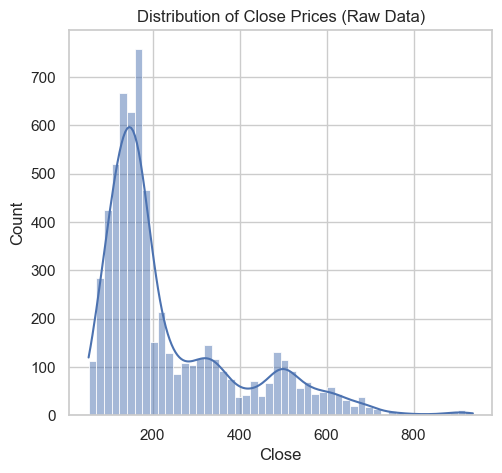

In [19]:

# Distribution of Close and Volume (log scale for Volume)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df_raw['Close'], bins=50, kde=True)
plt.title("Distribution of Close Prices (Raw Data)")


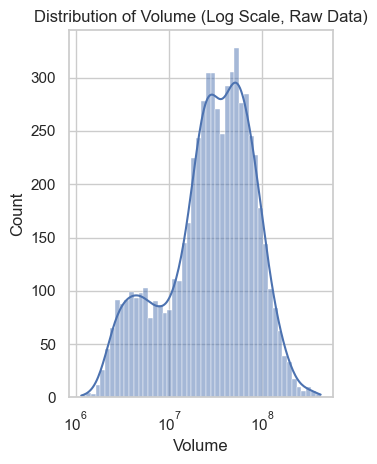

In [20]:

plt.subplot(1,2,2)
sns.histplot(df_raw['Volume'], bins=50, kde=True, log_scale=True)
plt.title("Distribution of Volume (Log Scale, Raw Data)")
plt.tight_layout()
plt.show()



### Closing Price of FAANG Stocks from 2020-2024

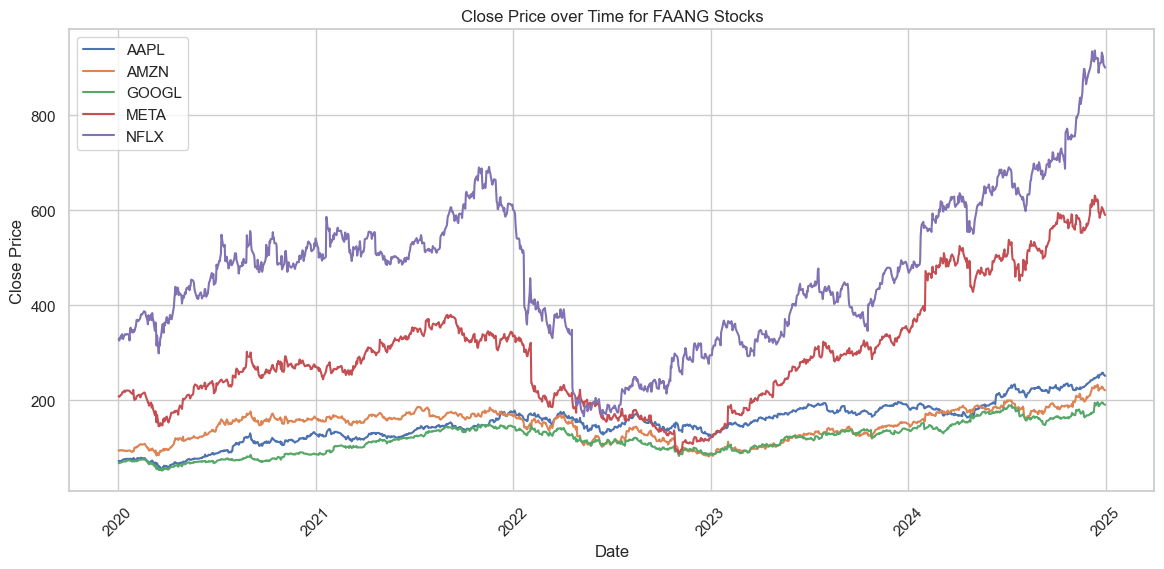

In [21]:


sample_symbols = df_raw['Symbol'].unique()
plt.figure(figsize=(14,6))
for symbol in sample_symbols:
    subset = df_raw[df_raw['Symbol'] == symbol]
    plt.plot(subset['Date'], subset['Close'], label=symbol)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Close Price over Time for FAANG Stocks")
plt.legend()
plt.xticks(rotation=45)
plt.show()




### Distribution of OHLC by Stock

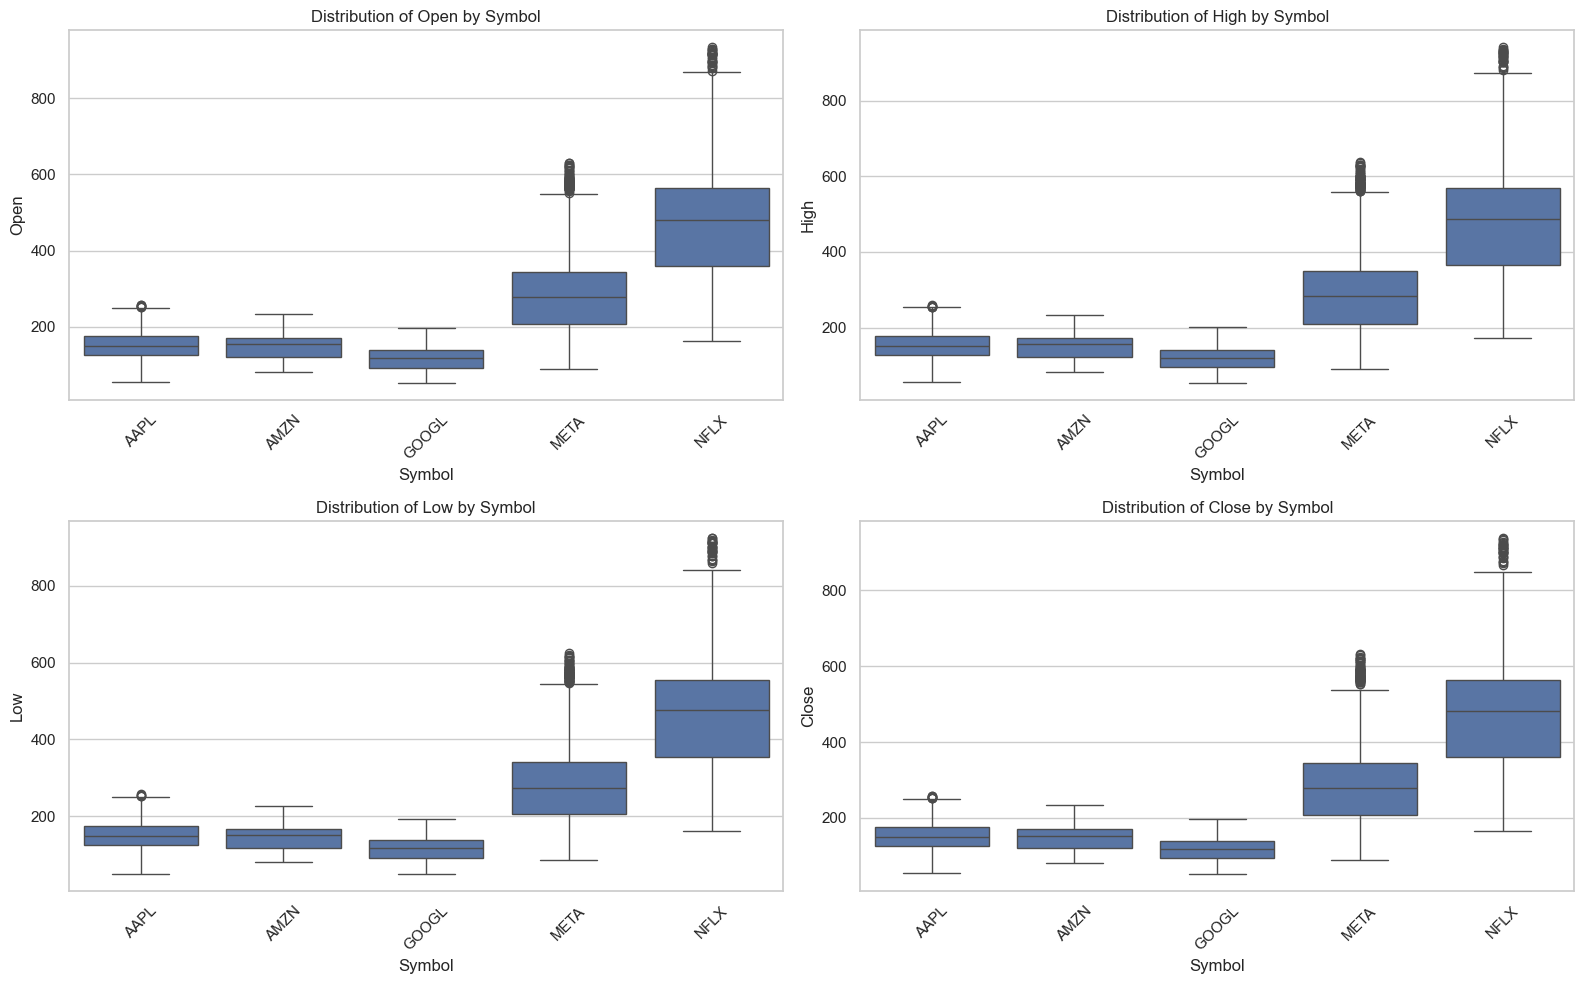

In [22]:
price_cols = ['Open', 'High', 'Low', 'Close']
plt.figure(figsize=(16,10))
for i, col in enumerate(price_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='Symbol', y=col, data=df_raw)
    plt.title(f"Distribution of {col} by Symbol")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Missing Value Checks

In [23]:

# Check for days with zero volume by symbol
zero_volume_counts = df_raw[df_raw['Volume'] == 0].groupby('Symbol').size()
print("\nDays with zero volume per symbol:")
print(zero_volume_counts)




Days with zero volume per symbol:
Series([], dtype: int64)


In [24]:
# Check for days with missing Open prices by symbol
missing_open_counts = df_raw[df_raw['Open'].isnull()].groupby('Symbol').size()
print("\nDays with missing Open price per symbol:")
print(missing_open_counts)




Days with missing Open price per symbol:
Series([], dtype: int64)


### Plotting Trading Volume Over Time

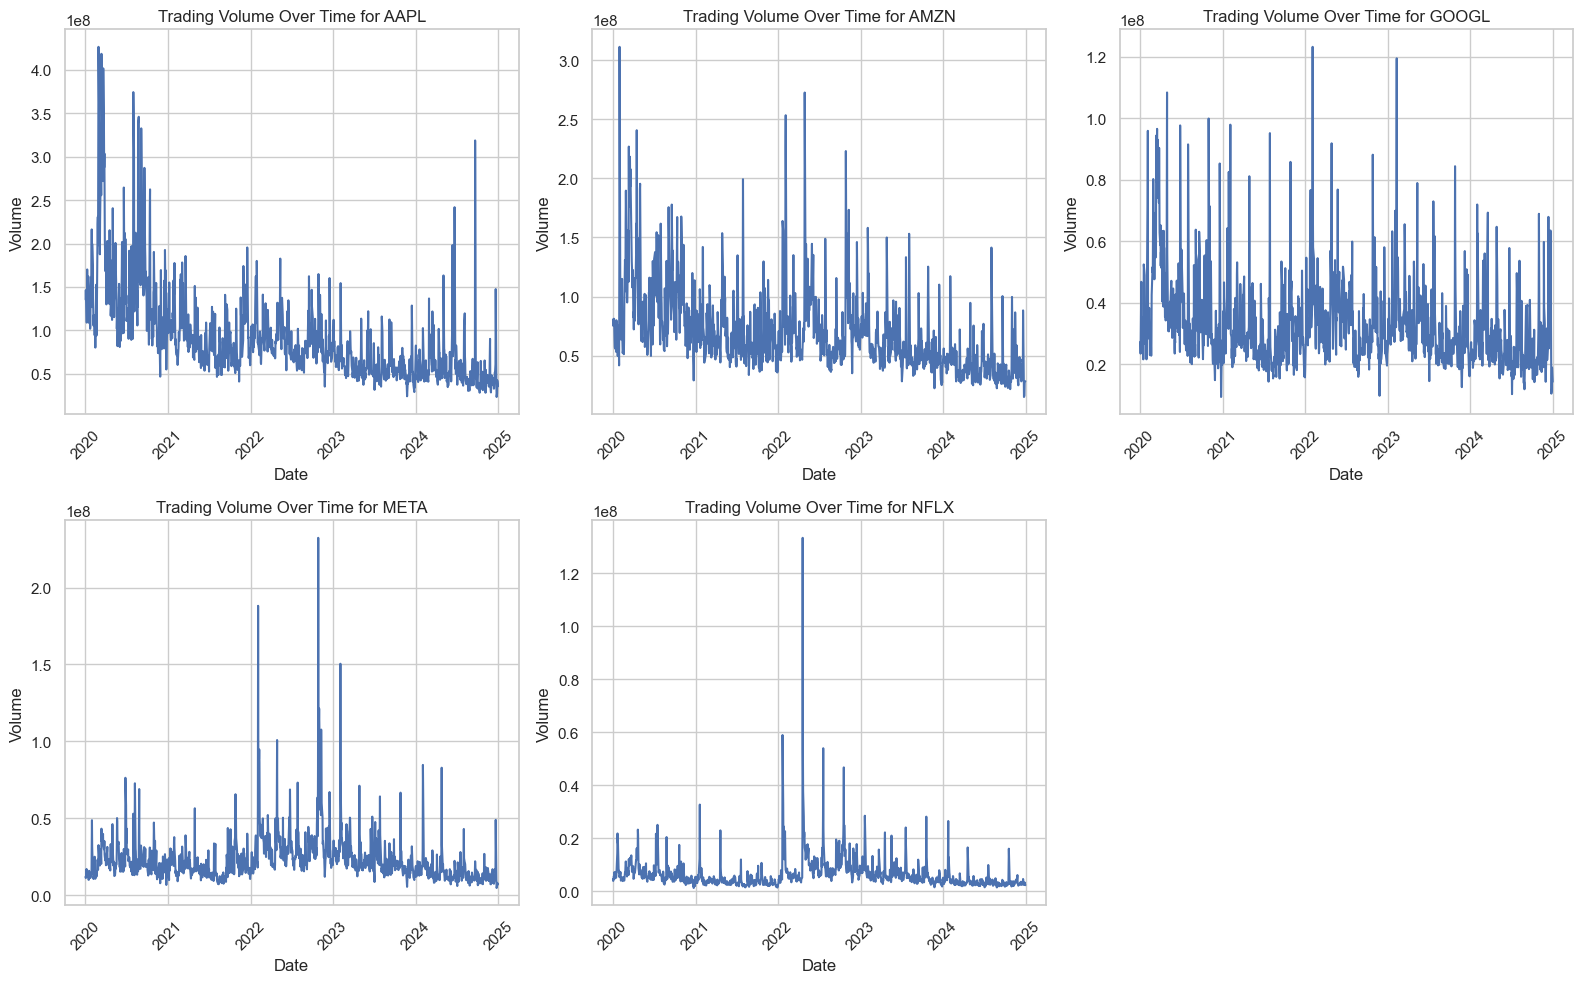

In [25]:
plt.figure(figsize=(16,10))
for i, col in enumerate(sample_symbols, 1):
    #plt.figure(figsize=(14,6))
    sample_symbol = col
    subset = df_raw[df_raw['Symbol'] == sample_symbol]
    plt.subplot(2, 3, i)
    plt.plot(subset['Date'], subset['Volume'])
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.title(f'Trading Volume Over Time for {sample_symbol}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



### Calling all feature engineering functions

In [26]:
df = delete_bad_data(df)

In [27]:
df = RSI(df)

In [28]:
df = PROC(df)

In [29]:
df = SO(df)

In [30]:
df = Williams_R(df)

In [31]:
df = OBV(df)

In [32]:
df = add_ewma(df)

In [33]:
df = detrend_close(df)

In [34]:
df = calculate_targets(df,1)

In [35]:
df = calculate_targets(df,30)

In [36]:
df.dropna(inplace=True)

In [37]:
df.to_csv("engineered_stock_data.csv", index=False)

In [38]:
df.head()

Variable,Date,Symbol,Close,High,Low,Open,Volume,RSI,PROC,SO,WR,OBV,EWMA,Close_detrend,Target(1),Target(30)
14,2020-01-06,NFLX,335.829987,336.359985,321.200012,323.119995,5663100.0,58.706739,0.062860,13.708811,-4.835912,621266000.0,333.075374,-9.674617,-1.0,-1.0
15,2020-01-07,AAPL,72.146935,72.753816,71.926907,72.497522,108872000.0,63.003185,0.070202,0.000000,2.347589,474728400.0,72.218077,-10.003011,-1.0,-1.0
16,2020-01-07,AMZN,95.343002,95.694504,94.601997,95.224998,80898000.0,52.436792,0.030520,6.765649,-4.414993,312788400.0,95.167576,-12.372070,1.0,-1.0
17,2020-01-07,GOOGL,69.339645,69.756647,69.163206,69.605552,34330000.0,53.472186,0.064680,0.000000,-49.328492,475022400.0,69.211786,-10.364785,1.0,-1.0
18,2020-01-07,META,211.897522,213.409233,210.594672,211.658841,14912400.0,54.672384,0.069758,0.000000,-9.601739,691251600.0,211.385583,-8.862834,-1.0,-1.0


## EDA of Data after Feature Engineering 

In [39]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Quick look at the data
print("=== Dataset head ===")
display(df.head())


=== Dataset head ===


Variable,Date,Symbol,Close,High,Low,Open,Volume,RSI,PROC,SO,WR,OBV,EWMA,Close_detrend,Target(1),Target(30)
14,2020-01-06,NFLX,335.829987,336.359985,321.200012,323.119995,5663100.0,58.706739,0.062860,13.708811,-4.835912,621266000.0,333.075374,-9.674617,-1.0,-1.0
15,2020-01-07,AAPL,72.146935,72.753816,71.926907,72.497522,108872000.0,63.003185,0.070202,0.000000,2.347589,474728400.0,72.218077,-10.003011,-1.0,-1.0
16,2020-01-07,AMZN,95.343002,95.694504,94.601997,95.224998,80898000.0,52.436792,0.030520,6.765649,-4.414993,312788400.0,95.167576,-12.372070,1.0,-1.0
17,2020-01-07,GOOGL,69.339645,69.756647,69.163206,69.605552,34330000.0,53.472186,0.064680,0.000000,-49.328492,475022400.0,69.211786,-10.364785,1.0,-1.0
18,2020-01-07,META,211.897522,213.409233,210.594672,211.658841,14912400.0,54.672384,0.069758,0.000000,-9.601739,691251600.0,211.385583,-8.862834,-1.0,-1.0


In [40]:
print("\n=== Dataset info ===")
print(df.info())


=== Dataset info ===
<class 'pandas.core.frame.DataFrame'>
Index: 6065 entries, 14 to 6254
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           6065 non-null   datetime64[ns]
 1   Symbol         6065 non-null   object        
 2   Close          6065 non-null   object        
 3   High           6065 non-null   object        
 4   Low            6065 non-null   object        
 5   Open           6065 non-null   object        
 6   Volume         6065 non-null   object        
 7   RSI            6065 non-null   float64       
 8   PROC           6065 non-null   float64       
 9   SO             6065 non-null   float64       
 10  WR             6065 non-null   float64       
 11  OBV            6065 non-null   float64       
 12  EWMA           6065 non-null   float64       
 13  Close_detrend  6065 non-null   float64       
 14  Target(1)      6065 non-null   float64       
 15  Tar

In [41]:
print("\n=== Summary statistics ===")
display(df.describe())


=== Summary statistics ===


Variable,Date,RSI,PROC,SO,WR,OBV,EWMA,Close_detrend,Target(1),Target(30)
count,6065,6065.000000,6065.000000,6065.000000,6065.000000,6.065000e+03,6065.000000,6065.000000,6065.000000,6065.000000
mean,2022-06-28 15:12:54.608408832,51.290614,0.014394,43.265544,-38.742160,1.148806e+09,236.629407,-2.926025,0.050618,0.253421
min,2020-01-06 00:00:00,10.748793,-0.503457,0.000000,-100.000000,-2.701952e+09,52.843318,-301.263943,-1.000000,-1.000000
25%,2021-04-01 00:00:00,42.949765,-0.033278,6.775967,-77.892666,1.110118e+08,129.895344,-26.372121,-1.000000,-1.000000
50%,2022-06-28 00:00:00,51.311847,0.018620,36.470418,-35.522675,9.048766e+08,170.151031,1.996097,1.000000,1.000000
75%,2023-09-25 00:00:00,59.748310,0.064917,78.937250,-5.338619,1.948710e+09,308.936834,29.847710,1.000000,1.000000
max,2024-12-19 00:00:00,90.437186,0.440535,100.000000,100.000000,3.946271e+09,929.388006,290.728457,1.000000,1.000000
std,NaN,12.052253,0.084794,36.699049,42.808519,1.115338e+09,160.751169,78.728463,0.997809,0.967436


In [42]:
print("\n=== Missing values ===")
print(df.isnull().sum())


=== Missing values ===
Variable
Date             0
Symbol           0
Close            0
High             0
Low              0
Open             0
Volume           0
RSI              0
PROC             0
SO               0
WR               0
OBV              0
EWMA             0
Close_detrend    0
Target(1)        0
Target(30)       0
dtype: int64


In [43]:
# Check unique symbols
print(f"\nUnique stock symbols: {df['Symbol'].nunique()}")
print(f"Symbols: {df['Symbol'].unique()}")


Unique stock symbols: 5
Symbols: ['NFLX' 'AAPL' 'AMZN' 'GOOGL' 'META']


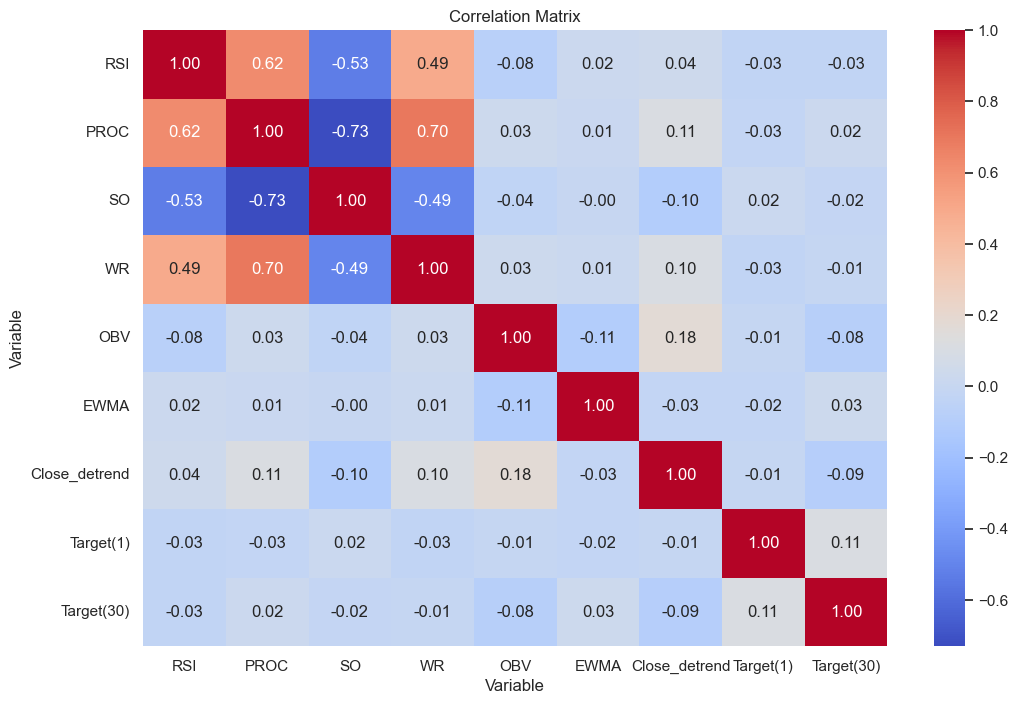

In [44]:
# Correlation heatmap of numeric features
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(12,8))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

### Boxplots of Engineered Features by Stock

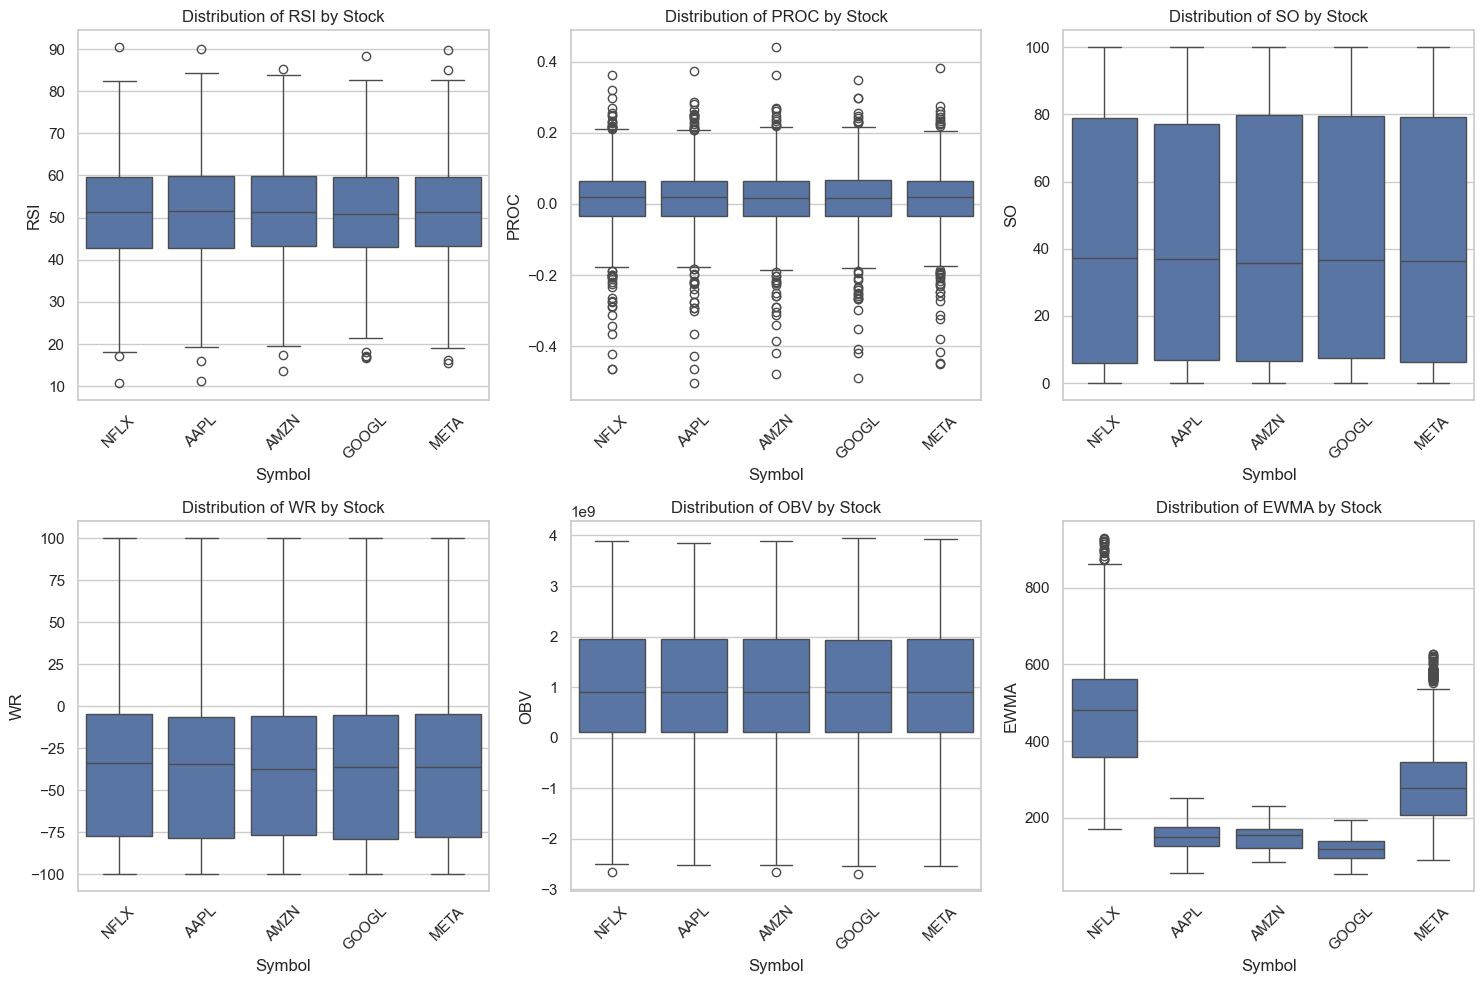

In [ ]:
features_to_plot = ['RSI', 'PROC', 'SO', 'WR', 'OBV', 'EWMA']
plt.figure(figsize=(15,10))
for i, feat in enumerate(features_to_plot, 1):
    plt.subplot(2,3,i)
    sns.boxplot(x='Symbol', y=feat, data=df)
    plt.title(f"Distribution of {feat} by Stock")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Analyze target distribution


Distribution of Target(1):
Target(1)
 1.0    3180
-1.0    2873
 0.0      12
Name: count, dtype: int64


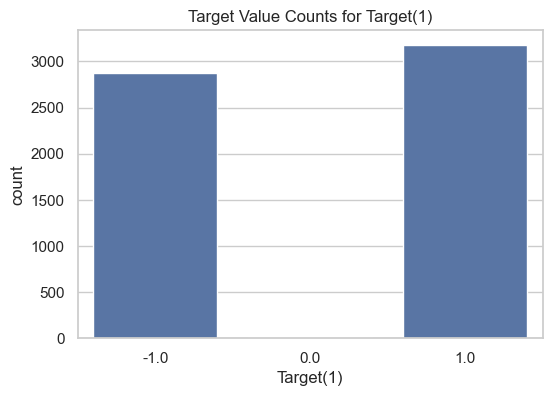


Distribution of Target(30):
Target(30)
 1.0    3801
-1.0    2264
Name: count, dtype: int64


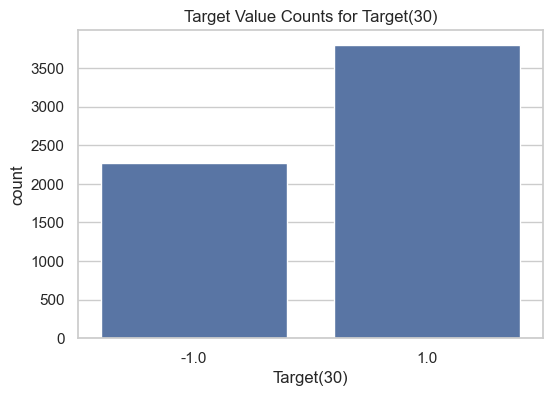

In [46]:
target_cols = [col for col in df.columns if 'Target' in col]
for target in target_cols:
    print(f"\nDistribution of {target}:")
    print(df[target].value_counts(dropna=False))

    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=target)
    plt.title(f"Target Value Counts for {target}")
    plt.show()


### Grouped summary: mean RSI by Stock

In [47]:
rsi_summary = df.groupby('Symbol')['RSI'].mean().sort_values()
print("\nMean RSI by Symbol:")
print(rsi_summary)



Mean RSI by Symbol:
Symbol
NFLX     51.183615
AAPL     51.225761
AMZN     51.271866
GOOGL    51.375454
META     51.396376
Name: RSI, dtype: float64


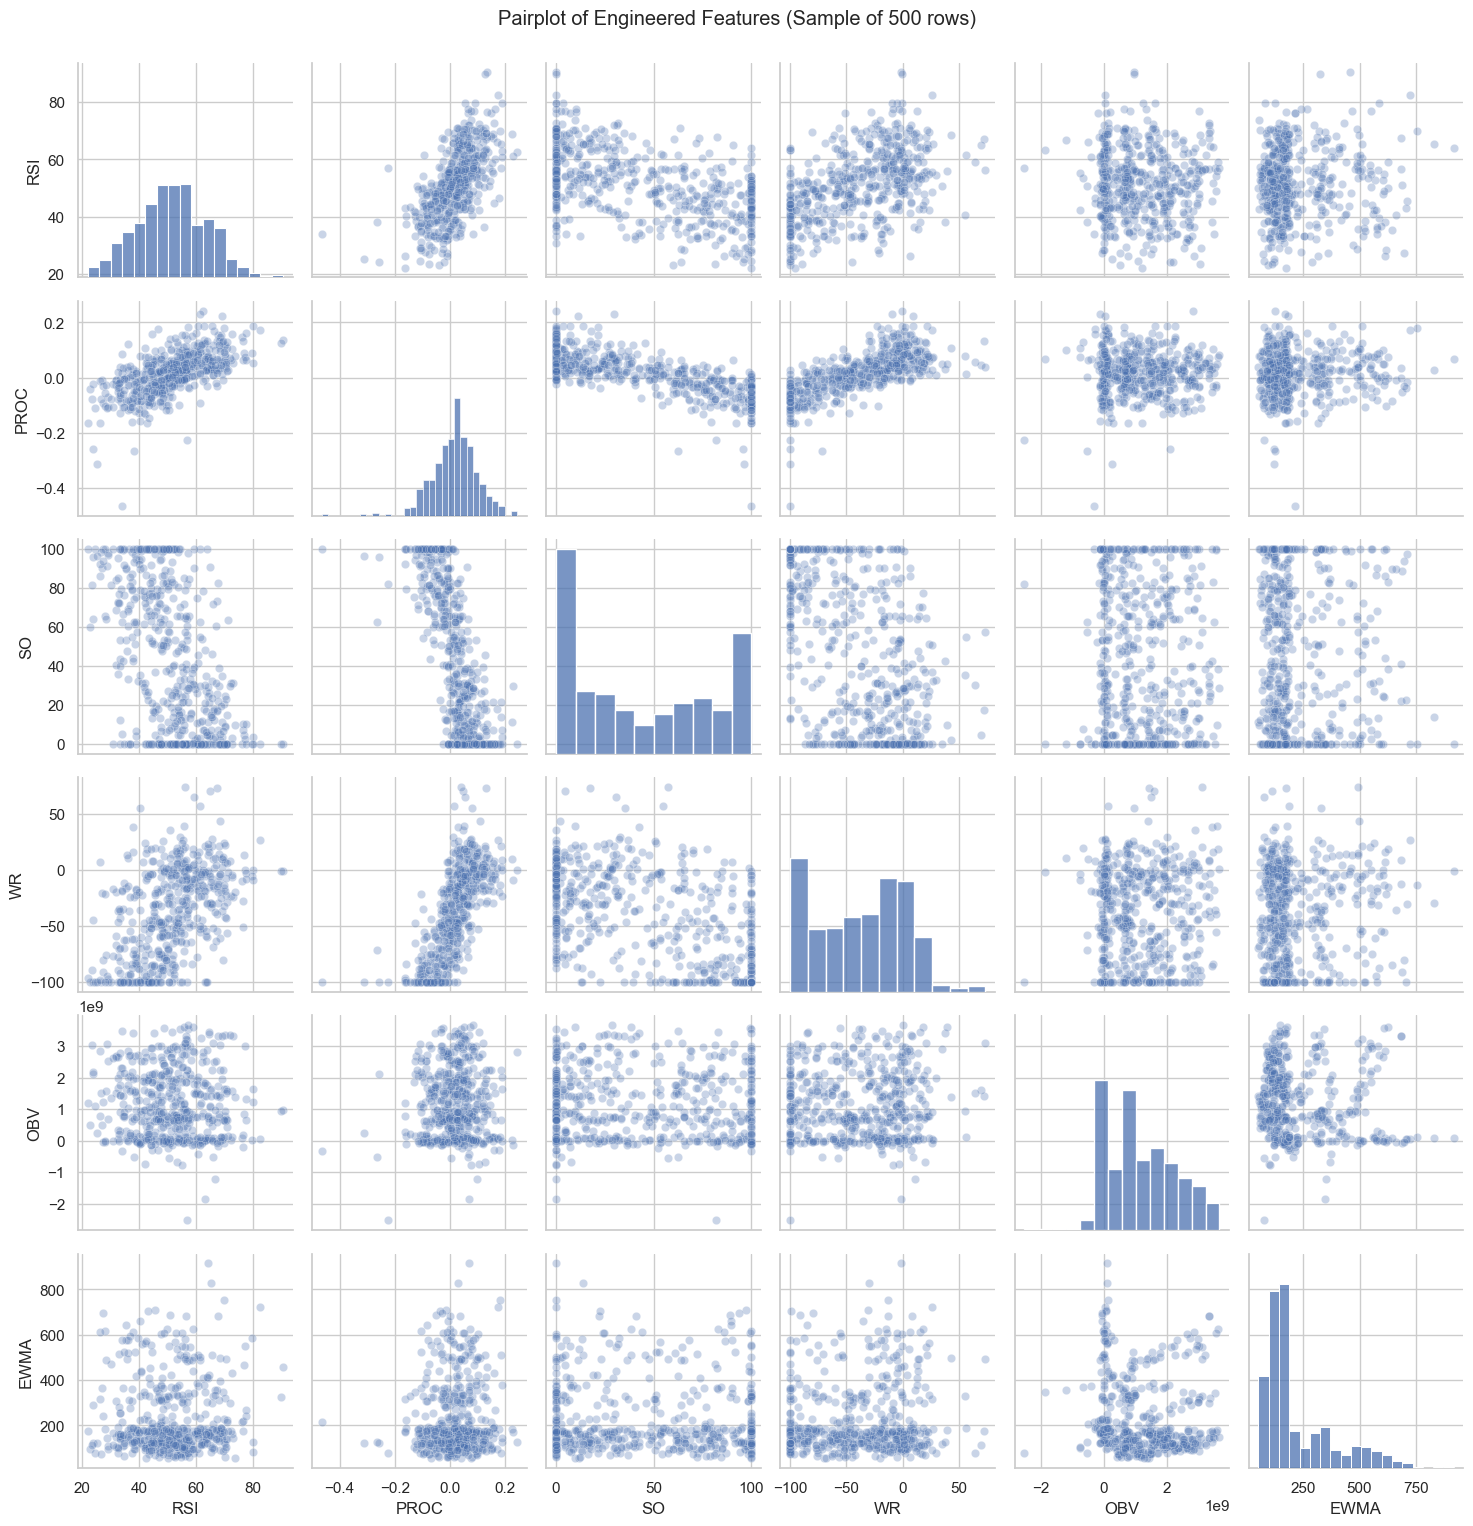

In [48]:
selected_features = ['RSI', 'PROC', 'SO', 'WR', 'OBV', 'EWMA']
sns.pairplot(df[selected_features].sample(500), kind='scatter', plot_kws={'alpha':0.3})
plt.suptitle("Pairplot of Engineered Features (Sample of 500 rows)", y=1.02)
plt.show()

### Building the Baseline Model Using Random Forest

In [49]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as make_forest



# Parameters
criterion = "gini"
num_features = 6
n_estimators = 65
prediction_window = 1  # Days ahead to predict
oob_score = True

# Load your preprocessed data CSV with all features + targets
full_data = pd.read_csv('engineered_stock_data.csv')

# Features to use for training
train_labels = ["Close_detrend", "Volume", "EWMA", "SO", "WR", "RSI"]

# Drop unused columns and rows with any missing data
selected_data = full_data.dropna(axis=0, how='any')
#selected_data.drop(["Unnamed: 0", "Date", "Open", "High", "Low"], axis=1, inplace=True)
print(selected_data.columns)
def split_x_y(df, feature_cols, pred_window):
    """
    Splits dataframe into features X and target y arrays for a specific prediction window.
    """
    x = df[feature_cols].values
    y = df[f'Target({pred_window})'].values
    return x, y

def train_on_df(x, y, train_frac):
    # If y has NaNs, remove those rows first
    mask = ~np.isnan(y)
    x_clean = x[mask]
    y_clean = y[mask]

    # If too few samples after cleaning, skip
    if len(x_clean) < 2:
        print("Not enough data after cleaning to train/test split.")
        return None, None

    train_x, test_x, train_y, test_y = train_test_split(
        x_clean, y_clean, train_size=train_frac, stratify=y_clean, random_state=42
    )

    # Train Random Forest
    Random_Forest = make_forest(
        n_estimators=n_estimators,
        max_features=num_features,
        bootstrap=True,
        oob_score=oob_score,
        verbose=0,
        criterion=criterion,
        n_jobs=-1
    )
    Random_Forest.fit(train_x, train_y)

    test_accuracy = Random_Forest.score(test_x, test_y)
    return Random_Forest, test_accuracy

    
 

# Train models per stock and predict for 1-day and 30-day targets
stock_forests = {}
num_symbols = len(selected_data['Symbol'].unique())
print(f"Training models for {num_symbols} stocks...")



from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as make_forest
import os
import tqdm

# Make sure the results folder exists
os.makedirs("results", exist_ok=True)
from collections import Counter

def can_stratify(y):
    """Returns True if all classes in y have at least 2 samples"""
    counts = Counter(y)
    return len(counts) > 1 and all(count >= 2 for count in counts.values())

for idx, stock in enumerate(tqdm.tqdm(selected_data['Symbol'].unique(), desc="Stocks")):
    stock_df = selected_data[selected_data["Symbol"] == stock]

    # Split data for Target(1)
    x1, y1 = split_x_y(stock_df, train_labels, 1)
    # Split data for Target(30)
    x30, y30 = split_x_y(stock_df, train_labels, 30)

    # Check if both splits have enough data
    if len(x1) < 10 or len(x30) < 10:
        print(f"Skipping {stock}: insufficient data for one or both targets.")
        continue

    # Check if we can stratify for 1-day
    if can_stratify(y1):
        stratify_y1 = y1
    else:
        stratify_y1 = None
        #print(f"Class distribution for {stock} 1-day target: {Counter(y1)}")
        print(f"⚠️ Warning: Not stratifying for 1-day target on {stock}")

    # Check if we can stratify for 30-day
    if can_stratify(y30):
        stratify_y2 = y30
    else:
        stratify_y2 = None
        print(f"⚠️ Warning: Not stratifying for 30-day target on {stock}")

    # Split safely
    x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.2, stratify=stratify_y1, random_state=42)
    x30_train, x30_test, y30_train, y30_test = train_test_split(x30, y30, test_size=0.2, stratify=stratify_y2, random_state=42)

    # Train Random Forest models
    forest1 = make_forest(random_state=42)
    forest30 = make_forest(random_state=42)

    forest1.fit(x1_train, y1_train)
    forest30.fit(x30_train, y30_train)

    # Evaluate accuracy
    acc1 = forest1.score(x1_test, y1_test)
    acc30 = forest30.score(x30_test, y30_test)

    print(f"Trained {stock} — Acc(1): {acc1:.4f}, Acc(30): {acc30:.4f}")
    stock_forests[stock] = {
    1: {"forest": forest1, "acc": acc1},
    30: {"forest": forest30, "acc": acc30}
    }
    # Predict on full feature rows (same as used to train)
    df_stock = stock_df.copy()
    df_stock["Prediction(1)"] = forest1.predict(x1)
    df_stock["Prediction(30)"] = forest30.predict(x30)


    # Save the DataFrame to CSV
    df_stock.to_csv(f"results/result_{stock}.csv", index=False)
    print(f"Saved predictions for {stock} ({idx + 1}/{len(selected_data['Symbol'].unique())})")


# Save overall accuracies
with open("results/_ALL.csv", "w") as f_all:
    f_all.write("Symbol,accPrediction(1),accPrediction(30)\n")
    for symb, vals in stock_forests.items():
        f_all.write(f"{symb},{vals[1]['acc']},{vals[30]['acc']}\n")

# Train forest on full market data
x1_full, y1_full = split_x_y(selected_data, train_labels, 1)
x30_full, y30_full = split_x_y(selected_data, train_labels, 30)
complete_forest1, complete_acc1 = train_on_df(x1_full, y1_full,0.8)
complete_forest30, complete_acc30 = train_on_df(x30_full, y30_full,0.8)

print(f"\nFull market model accuracy:")
print(f"  1-day prediction accuracy: {complete_acc1*100:.2f}%")
print(f" 30-day prediction accuracy: {complete_acc30*100:.2f}%")

# Compare full market model vs some stocks
to_compare = ['META','AMZN','AAPL','NFLX','GOOGL']
print("\nComparing full market model on selected stocks:")
for stock in to_compare:
    stock_df = selected_data[selected_data["Symbol"] == stock]

    x1, y1 = split_x_y(stock_df, train_labels, 1)
    x30, y30 = split_x_y(stock_df, train_labels, 30)
    if len(x1) == 0 or len(x30) == 0:
        print(f"Skipping {stock} due to insufficient data for full model evaluation.")
        continue
    acc1 = complete_forest1.score(x1, y1)
    acc30 = complete_forest30.score(x30, y30)

    print(f"For {stock}:")
    print(f"\t1-day accuracy: {acc1*100:.2f}%")
    print(f"\t30-day accuracy: {acc30*100:.2f}%")

# Cross-stock model testing
print("\nCross-stock model testing:")
for model_stock in to_compare:
    for test_stock in to_compare:
        if test_stock == model_stock:
            continue

        stock_df = selected_data[selected_data["Symbol"] == test_stock]

        x1, y1 = split_x_y(stock_df, train_labels, 1)
        x30, y30 = split_x_y(stock_df, train_labels, 30)
        assert len(x1) == len(y1), f"Mismatch length in features/labels for {model_stock}"
        if len(x1) == 0:
            print(f"No data to score for {model_stock}")
            continue
        print()
        acc1 = stock_forests[model_stock][1]["forest"].score(x1, y1)
        acc30 = stock_forests[model_stock][30]["forest"].score(x30, y30)

        print(f"Test {test_stock} on model trained on {model_stock}:")
        print(f"\t1-day accuracy: {acc1*100:.2f}%")
        print(f"\t30-day accuracy: {acc30*100:.2f}%")


Index(['Date', 'Symbol', 'Close', 'High', 'Low', 'Open', 'Volume', 'RSI',
       'PROC', 'SO', 'WR', 'OBV', 'EWMA', 'Close_detrend', 'Target(1)',
       'Target(30)'],
      dtype='object')
Training models for 5 stocks...


Stocks:  20%|██        | 1/5 [00:00<00:01,  3.13it/s]

Trained NFLX — Acc(1): 0.4938, Acc(30): 0.6831
Saved predictions for NFLX (1/5)


Stocks:  40%|████      | 2/5 [00:00<00:00,  3.18it/s]

Trained AAPL — Acc(1): 0.5432, Acc(30): 0.6337
Saved predictions for AAPL (2/5)
⚠️ Warning: Not stratifying for 1-day target on AMZN


Stocks:  60%|██████    | 3/5 [00:00<00:00,  3.19it/s]

Trained AMZN — Acc(1): 0.5267, Acc(30): 0.6379
Saved predictions for AMZN (3/5)


Stocks:  80%|████████  | 4/5 [00:01<00:00,  3.20it/s]

Trained GOOGL — Acc(1): 0.4979, Acc(30): 0.6667
Saved predictions for GOOGL (4/5)


Stocks: 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]

Trained META — Acc(1): 0.4938, Acc(30): 0.6584
Saved predictions for META (5/5)



Full market model accuracy:
  1-day prediction accuracy: 48.97%
 30-day prediction accuracy: 68.67%

Comparing full market model on selected stocks:
For META:
	1-day accuracy: 90.02%
	30-day accuracy: 93.90%
For AMZN:
	1-day accuracy: 90.27%
	30-day accuracy: 93.98%
For AAPL:
	1-day accuracy: 88.29%
	30-day accuracy: 92.75%
For NFLX:
	1-day accuracy: 89.69%
	30-day accuracy: 94.31%
For GOOGL:
	1-day accuracy: 90.68%
	30-day accuracy: 93.65%

Cross-stock model testing:

Test AMZN on model trained on META:
	1-day accuracy: 51.03%
	30-day accuracy: 61.75%

Test AAPL on model trained on META:
	1-day accuracy: 51.94%
	30-day accuracy: 61.01%

Test NFLX on model trained on META:
	1-day accuracy: 47.73%
	30-day accuracy: 57.38%

Test GOOGL on model trained on META:
	1-day accuracy: 52.43%
	30-day accuracy: 62.65%

Test META on model trained on AMZN:
	1-day accuracy: 47.57%
	30-day accuracy: 63.31%

Test AAPL on model trained on AMZN:
	1-day accuracy: 49.55%
	30-day accuracy: 65.38%

Test NFL

### Feature Importance Model for Target 1 vs Target 30 for each Stock

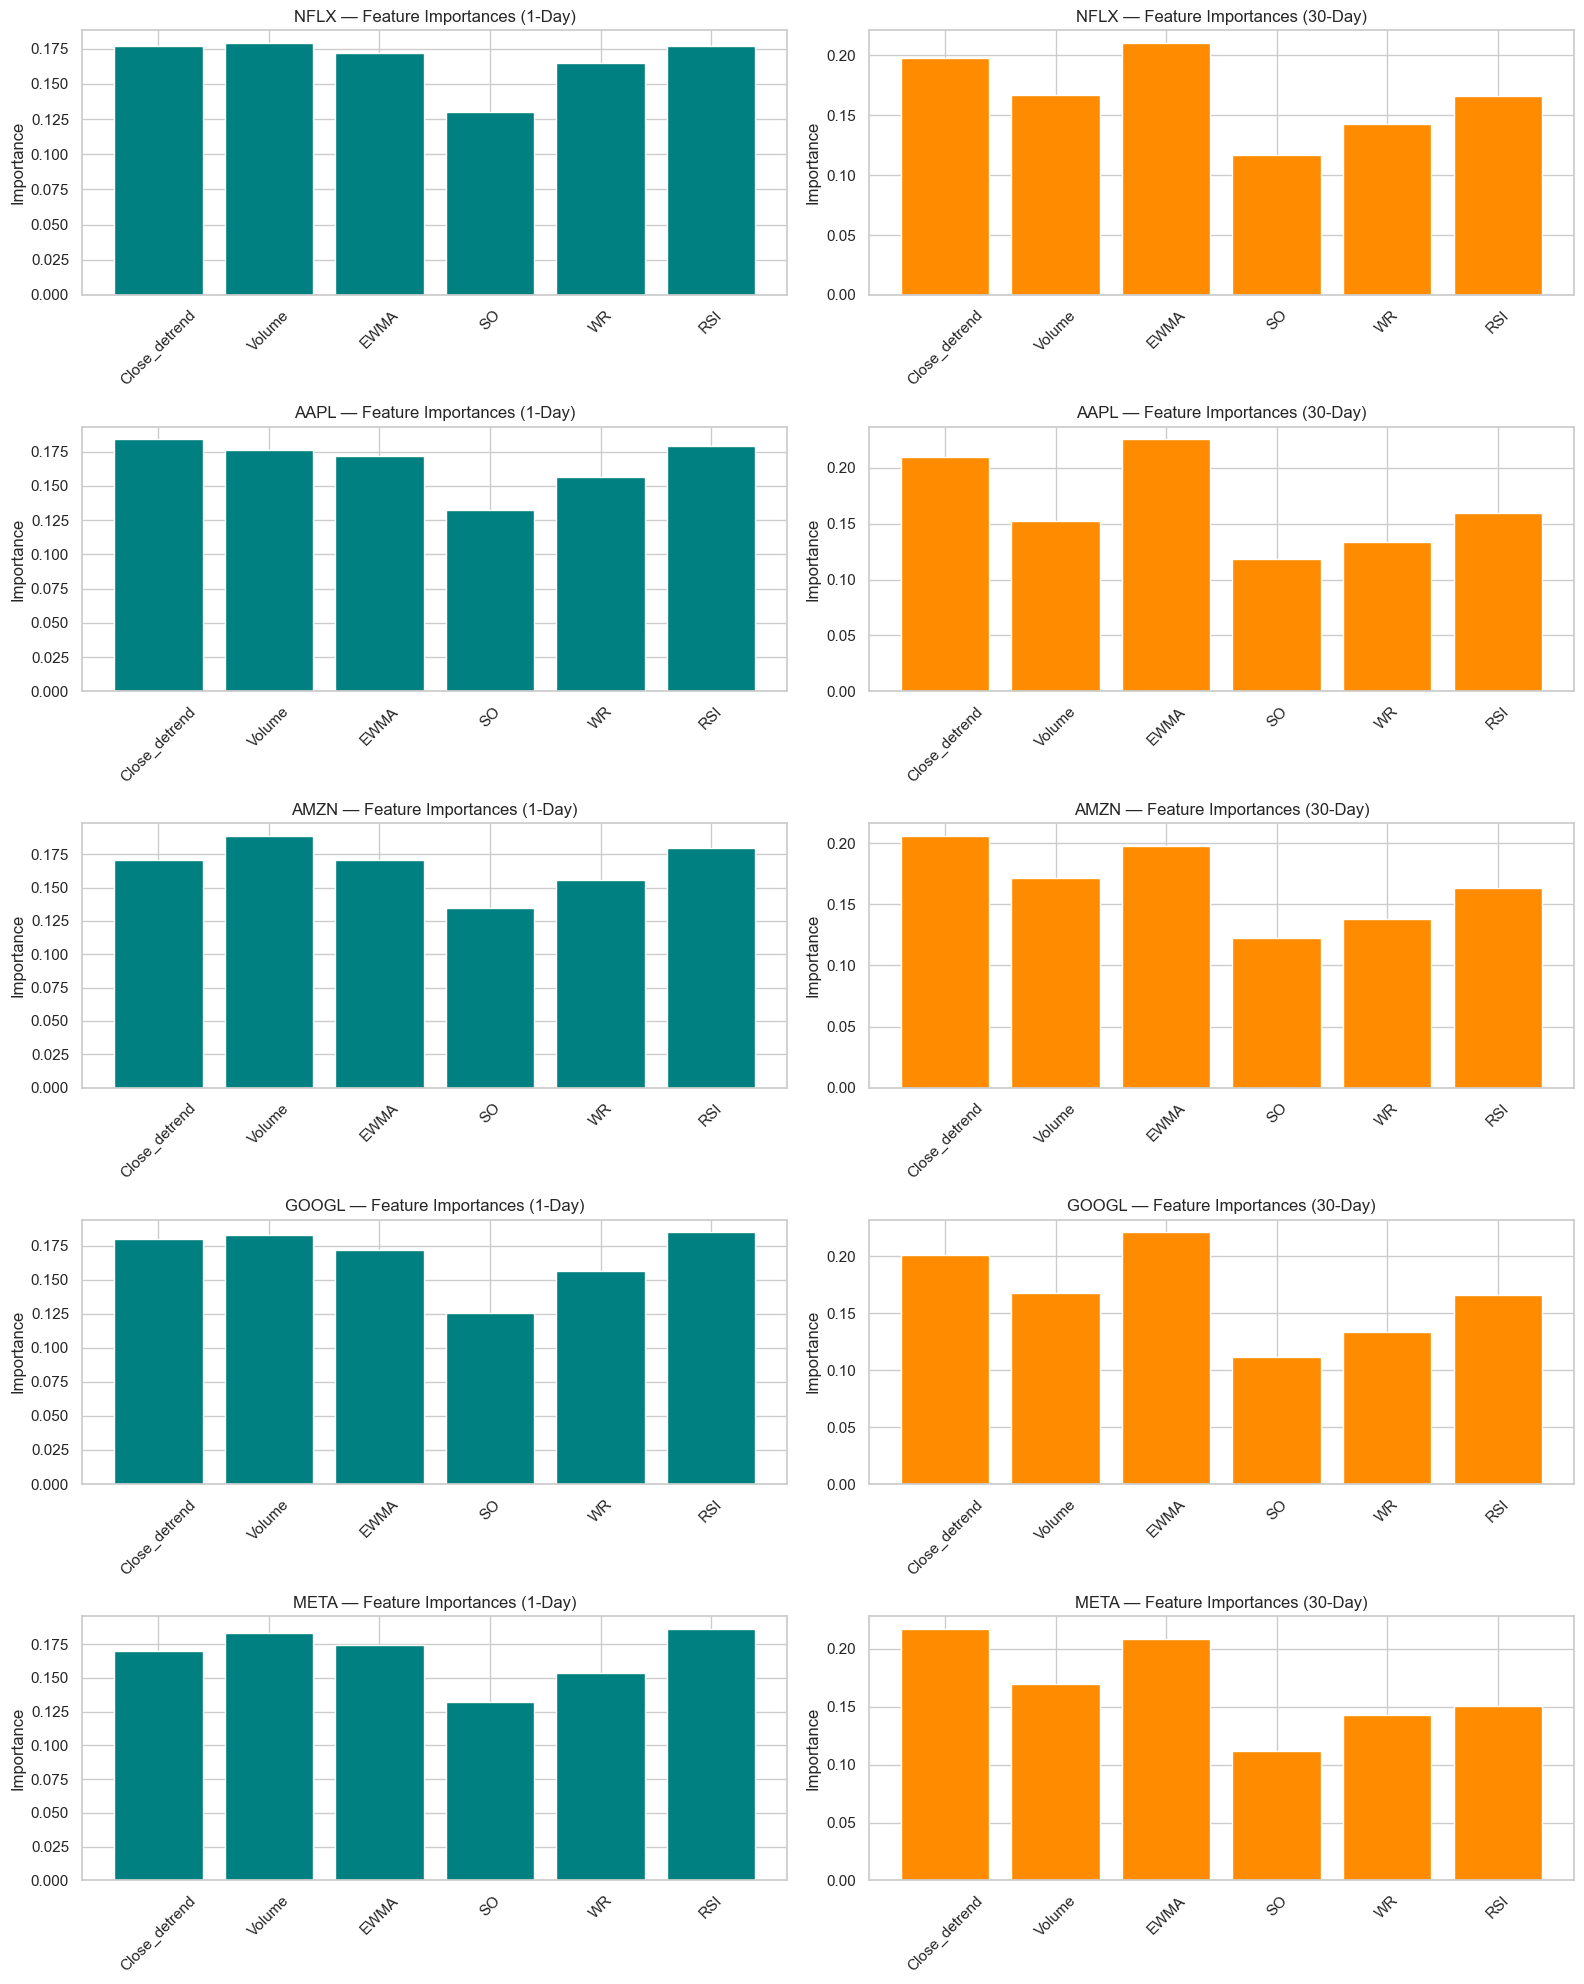

In [50]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 20)) 

for i, stock in enumerate(stock_forests):
    # Get models
    forest1 = stock_forests[stock][1]["forest"]
    forest30 = stock_forests[stock][30]["forest"]

    importances1 = forest1.feature_importances_
    importances30 = forest30.feature_importances_

    # Subplot for 1-day model
    plt.subplot(5, 2, 2 * i + 1)
    plt.bar(train_labels, importances1, color="teal")
    plt.title(f"{stock} — Feature Importances (1-Day)")
    plt.ylabel("Importance")
    plt.xticks(rotation=45)

    # Subplot for 30-day model
    plt.subplot(5, 2, 2 * i + 2)
    plt.bar(train_labels, importances30, color="darkorange")
    plt.title(f"{stock} — Feature Importances (30-Day)")
    plt.ylabel("Importance")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
